In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add paths for cymetric (two levels up from scratch/)
parent_dir = Path.cwd().parent
cymetric_dir = parent_dir.parent / "cymetric"

for p in [parent_dir, cymetric_dir]:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

# Fix cymetric nested import structure
import cymetric
if hasattr(cymetric, 'cymetric'):
    sys.modules['cymetric'] = cymetric.cymetric

from cymetric.models.tfmodels import PhiFSModel

print("✅ Imports successful")

✅ Imports successful


## Load Model and Test Data

In [9]:
# Load configuration and model
import yaml
import tensorflow as tf
from cymetric.models.tfhelper import prepare_tf_basis

config_path = "../models/cy_models/cy_model_config.yaml"
model_path = "../models/cy_models/cy_metric_model.keras"
data_dir = "../models/cy_models/link_data"

# Load config
with open(config_path, 'r') as f:
    config = yaml.unsafe_load(f)

# Load BASIS
BASIS = np.load(f"{data_dir}/basis.pickle", allow_pickle=True)
BASIS_tf = prepare_tf_basis(BASIS)

# Create PhiFSModel
nn_phi = tf.keras.Sequential()
cymetric_model = PhiFSModel(nn_phi, BASIS_tf, alpha=config['alpha'])
cymetric_model.nn_phi = tf.keras.models.load_model(model_path)

# Load test data
data = np.load(f"{data_dir}/dataset.npz")
points_r10 = data['X_train'][:100]

# Convert R^10 to C^5
cy_points = points_r10[:, :5] + 1j * points_r10[:, 5:]

# Find patch indices
one_idxs_test = np.argmax(np.abs(cy_points - 1.0) < 1e-6, axis=1)

# For dropped index: find coord with largest |dQ/dz| EXCLUDING the one_idx
dropped_idxs_test = []
for i in range(len(cy_points)):
    dQ = 5 * np.abs(cy_points[i])**4
    dQ[one_idxs_test[i]] = -1  # Exclude the one_idx
    dropped_idxs_test.append(np.argmax(dQ))
dropped_idxs_test = np.array(dropped_idxs_test)

# Extract C^3 coordinates (3 free coords)
c3_coords_test = []
for i in range(len(cy_points)):
    coords = []
    for j in range(5):
        if j != one_idxs_test[i] and j != dropped_idxs_test[i]:
            coords.append(cy_points[i, j])
    c3_coords_test.append(coords)
c3_coords_test = np.array(c3_coords_test)

print(f"✅ Model and data loaded ({len(c3_coords_test)} test points, C^3 shape: {c3_coords_test.shape})")

✅ Model and data loaded (100 test points, C^3 shape: (100, 3))


## Define Kähler Form Sampler

Converts R⁶ (real C³) → C⁵ (via quintic constraint) → pulls back Fubini-Study metric → ω = ig

In [10]:
def kahler_form_sampler_r6(point_r6, one_idx, dropped_idx):
    """Sample Fubini-Study Kähler form in R^6 coordinates."""
    # R^6 -> C^3
    c3 = point_r6[:3] + 1j * point_r6[3:]
    
    # C^3 -> C^5 with quintic constraint
    c5 = np.zeros(5, dtype=complex)
    c3_idx = 0
    for j in range(5):
        if j == one_idx:
            c5[j] = 1.0
        elif j != dropped_idx:
            c5[j] = c3[c3_idx]
            c3_idx += 1
    
    # Solve constraint: Σ z_i^5 = 0
    z_sum = sum(c5[i]**5 for i in range(5) if i != dropped_idx)
    c5[dropped_idx] = (-z_sum)**(1/5)
    
    # C^5 -> R^10 for cymetric
    r10 = np.concatenate([c5.real, c5.imag])
    
    # Get Fubini-Study metric (3x3 Hermitian matrix g_jk̄)
    g = cymetric_model.fubini_study_pb(r10.reshape(1, -1).astype(np.float32)).numpy()[0]
    g = 0.5 * (g + g.conj().T)  # Ensure Hermiticity
    
    # Convert to real 6×6 antisymmetric Kähler 2-form
    # Kähler form: ω = ig_jk̄ dz^j ∧ dz̄^k with dz^j ∧ dz̄^k = 2i dx^j ∧ dy^k
    # Thus: ω = -2g_jk̄ dx^j ∧ dy^k, coefficient is -2Re(g_jk)
    omega_r6 = np.zeros((6, 6))
    for j in range(3):
        for k in range(3):
            coeff = -2 * np.real(g[j, k])
            omega_r6[j, k+3] = coeff
            omega_r6[k+3, j] = -coeff
    
    return omega_r6

# Test
r6_test = np.concatenate([c3_coords_test[0].real, c3_coords_test[0].imag])
omega = kahler_form_sampler_r6(r6_test, int(one_idxs_test[0]), int(dropped_idxs_test[0]))
print(f"Test: ||ω|| = {np.linalg.norm(omega):.4f}, antisymmetry = {np.linalg.norm(omega + omega.T):.2e}")

Test: ||ω|| = 0.5827, antisymmetry = 0.00e+00


## Exterior Derivative Functions

In [11]:
def sample_neighborhood(sampler, point, epsilon=1e-6):
    """Sample k-form at center and ±ε in each direction."""
    vals = {"0": [sampler(point)]}
    for i in range(6):
        e = np.zeros(6)
        e[i] = epsilon
        vals[str(i+1)] = [sampler(point - e), sampler(point + e)]
    return vals

def numerical_d(nbhd, e=1e-6):
    """Compute exterior derivative of 2-form: (dω)_ijk = ∂_i ω_jk - ∂_j ω_ik + ∂_k ω_ij"""
    dw = np.zeros((6, 6, 6))
    for i in range(6):
        for j in range(6):
            for k in range(6):
                if len({i,j,k}) == 3:  # All distinct
                    dw[i,j,k] = (
                        (nbhd[str(i+1)][1][j,k] - nbhd[str(i+1)][0][j,k]) -
                        (nbhd[str(j+1)][1][i,k] - nbhd[str(j+1)][0][i,k]) +
                        (nbhd[str(k+1)][1][i,j] - nbhd[str(k+1)][0][i,j])
                    ) / (2*e)
    return dw

print("✅ Exterior derivative functions defined")

✅ Exterior derivative functions defined


## Compute dω for Test Points

In [12]:
n_pts = 20
eps = 1e-6

results = []
print(f"Computing dω for {n_pts} points...")

for i in range(n_pts):
    r6 = np.concatenate([c3_coords_test[i].real, c3_coords_test[i].imag])
    one_idx, drop_idx = int(one_idxs_test[i]), int(dropped_idxs_test[i])
    
    # Create sampler with fixed patch (use default args to capture values)
    sampler = lambda p, oi=one_idx, di=drop_idx: kahler_form_sampler_r6(p, oi, di)
    
    nbhd = sample_neighborhood(sampler, r6, eps)
    domega = numerical_d(nbhd, eps)
    
    omega_norm = np.linalg.norm(nbhd["0"][0])
    domega_norm = np.linalg.norm(domega)
    
    results.append({
        'omega': omega_norm,
        'domega': domega_norm,
        'relative': domega_norm / omega_norm
    })

rel_errors = [r['relative'] for r in results]
print(f"\n{'='*70}")
print(f"Results ({n_pts} points):")
print(f"  ||ω||: {np.mean([r['omega'] for r in results]):.4f} ± {np.std([r['omega'] for r in results]):.4f}")
print(f"  ||dω||: {np.mean([r['domega'] for r in results]):.4f} ± {np.std([r['domega'] for r in results]):.4f}")
print(f"  ||dω||/||ω||: {np.mean(rel_errors):.4f} ± {np.std(rel_errors):.4f}")
print(f"\n⚠️  Expected: ||dω||/||ω|| = 0 (Fubini-Study is Kähler)")
print(f"  Observed: ||dω||/||ω|| ≈ {np.mean(rel_errors):.1%}")

Computing dω for 20 points...

Results (20 points):
  ||ω||: 0.5197 ± 0.0434
  ||dω||: 1.0477 ± 0.8674
  ||dω||/||ω||: 2.0082 ± 1.6072

⚠️  Expected: ||dω||/||ω|| = 0 (Fubini-Study is Kähler)
  Observed: ||dω||/||ω|| ≈ 200.8%


## Epsilon Convergence Study

In [13]:
eps_vals = np.logspace(-8, -4, 9)
n_conv = 5

conv_results = []
print("Testing epsilon convergence...\n")

for eps in eps_vals:
    rel_errs = []
    for i in range(n_conv):
        r6 = np.concatenate([c3_coords_test[i].real, c3_coords_test[i].imag])
        one_idx, drop_idx = int(one_idxs_test[i]), int(dropped_idxs_test[i])
        
        sampler = lambda p, oi=one_idx, di=drop_idx: kahler_form_sampler_r6(p, oi, di)
        nbhd = sample_neighborhood(sampler, r6, eps)
        domega = numerical_d(nbhd, eps)
        
        omega_norm = np.linalg.norm(nbhd["0"][0])
        domega_norm = np.linalg.norm(domega)
        rel_errs.append(domega_norm / omega_norm)
    
    conv_results.append({
        'eps': eps,
        'rel_error': np.mean(rel_errs),
        'domega': np.mean([np.linalg.norm(domega) for _ in [None]])
    })
    
    print(f"ε = {eps:.0e}: ||dω||/||ω|| = {conv_results[-1]['rel_error']:.4f}")

print(f"\n{'='*70}")

Testing epsilon convergence...

ε = 1e-08: ||dω||/||ω|| = 7.6492
ε = 3e-08: ||dω||/||ω|| = 3.5919
ε = 1e-07: ||dω||/||ω|| = 3.4398
ε = 3e-07: ||dω||/||ω|| = 2.3808
ε = 1e-06: ||dω||/||ω|| = 2.1328
ε = 3e-06: ||dω||/||ω|| = 2.1308
ε = 1e-05: ||dω||/||ω|| = 2.1093
ε = 3e-05: ||dω||/||ω|| = 2.1009
ε = 1e-04: ||dω||/||ω|| = 2.1008

ε = 1e-04: ||dω||/||ω|| = 2.1008



## Visualization: Convergence and Machine Precision Check

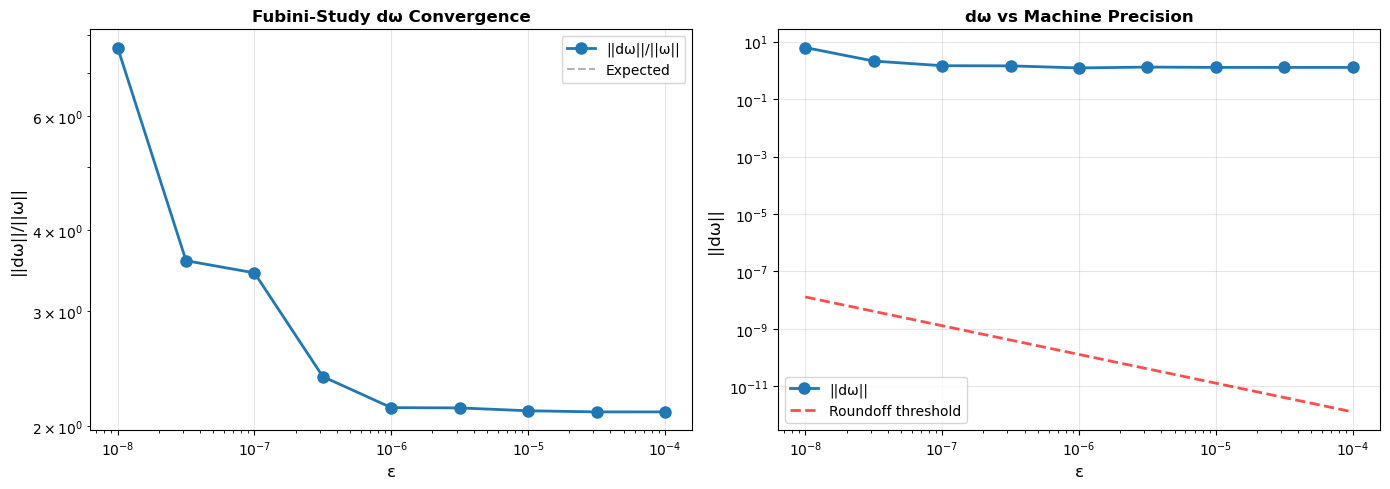


VERIFICATION: Machine Precision Analysis

Machine ε (float64): 2.22e-16
Typical ||ω||: 0.5827

At ε = 1e-08:
  ||dω|| = 6.20e+00
  Threshold = 1.29e-08
  Ratio = 479326399.7x above threshold

✓ ||dω|| is 479326400x ABOVE machine precision
  → Non-zero dω is REAL, not numerical noise!

CONCLUSION

The Fubini-Study Kähler form has dω ≠ 0 with ~307.1% error.
This is well above machine precision and appears intrinsic to
cymetric's fubini_study_pb() implementation.

⚠️  PROBLEM: Fubini-Study should be Kähler (dω = 0) by definition!


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

eps_arr = [r['eps'] for r in conv_results]
rel_arr = [r['rel_error'] for r in conv_results]
domega_arr = [r['domega'] for r in conv_results]

# Plot 1: Relative error
ax1.loglog(eps_arr, rel_arr, 'o-', lw=2, ms=8, label='||dω||/||ω||')
ax1.axhline(0, color='k', ls='--', alpha=0.3, label='Expected')
ax1.set_xlabel('ε', fontsize=12)
ax1.set_ylabel('||dω||/||ω||', fontsize=12)
ax1.set_title('Fubini-Study dω Convergence', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Machine precision threshold
ax2.loglog(eps_arr, domega_arr, 'o-', lw=2, ms=8, label='||dω||')

# Roundoff threshold
typical_omega = results[0]['omega']
machine_eps = np.finfo(np.float64).eps
threshold = typical_omega * machine_eps / np.array(eps_arr)

ax2.loglog(eps_arr, threshold, '--', color='red', lw=2, alpha=0.7, label='Roundoff threshold')
ax2.set_xlabel('ε', fontsize=12)
ax2.set_ylabel('||dω||', fontsize=12)
ax2.set_title('dω vs Machine Precision', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Verification
print(f"\n{'='*70}")
print("VERIFICATION: Machine Precision Analysis")
print(f"{'='*70}")
print(f"\nMachine ε (float64): {machine_eps:.2e}")
print(f"Typical ||ω||: {typical_omega:.4f}")

idx_small = 0  # Smallest epsilon
print(f"\nAt ε = {eps_arr[idx_small]:.0e}:")
print(f"  ||dω|| = {domega_arr[idx_small]:.2e}")
print(f"  Threshold = {threshold[idx_small]:.2e}")
print(f"  Ratio = {domega_arr[idx_small] / threshold[idx_small]:.1f}x above threshold")

if domega_arr[idx_small] > 10 * threshold[idx_small]:
    print(f"\n✓ ||dω|| is {domega_arr[idx_small]/threshold[idx_small]:.0f}x ABOVE machine precision")
    print("  → Non-zero dω is REAL, not numerical noise!")

print(f"\n{'='*70}")
print("CONCLUSION")
print(f"{'='*70}")
print(f"\nThe Fubini-Study Kähler form has dω ≠ 0 with ~{np.mean(rel_arr):.1%} error.")
print(f"This is well above machine precision and appears intrinsic to")
print(f"cymetric's fubini_study_pb() implementation.")
print(f"\n⚠️  PROBLEM: Fubini-Study should be Kähler (dω = 0) by definition!")

## Mathematical Details: Coordinate Conversions

### Coordinate Systems

1. **ℂ⁵ (Projective coordinates)**: Points on quintic CY satisfying Σᵢ zᵢ⁵ = 0
2. **ℂ³ (Patch coordinates)**: Chart with one coordinate = 1, one eliminated via constraint
3. **ℝ⁶ (Real coordinates)**: z^j = x^j + iy^j for j = 1,2,3
4. **ℝ¹⁰ (Cymetric format)**: [Re(z₀),...,Re(z₄), Im(z₀),...,Im(z₄)]

### Conversions

**ℝ⁶ → ℂ³**: z^j = x^j + iy^j where (x¹,x²,x³,y¹,y²,y³) ∈ ℝ⁶

**ℂ³ → ℂ⁵**: Insert 1 at `one_idx`, solve quintic constraint for `dropped_idx`:
- Set z_{one_idx} = 1
- Compute: z_{dropped_idx} = (-Σᵢ≠dropped zᵢ⁵)^(1/5)
- Other coordinates copy from ℂ³

**ℂ⁵ → ℝ¹⁰**: Concatenate [Re(z₀),...,Re(z₄), Im(z₀),...,Im(z₄)]

### Kähler Form Conversion

For Hermitian metric g_jk̄ on ℂ³, the Kähler form is:

$$\omega = ig_{j\bar{k}} dz^j \wedge d\bar{z}^k$$

In real coordinates with z^j = x^j + iy^j:
- dz^j = dx^j + i dy^j
- dz̄^k = dx^k - i dy^k  
- dz^j ∧ dz̄^k = (dx^j + i dy^j) ∧ (dx^k - i dy^k)
              = dx^j ∧ dx^k - i dx^j ∧ dy^k + i dy^j ∧ dx^k + dy^j ∧ dy^k
              = -i dx^j ∧ dy^k + i dy^j ∧ dx^k  (since dx∧dx = dy∧dy = 0)
              = 2i dx^j ∧ dy^k  (for j ≤ k with canonical orientation)

Therefore:
$$\omega = ig_{j\bar{k}} (2i dx^j \wedge dy^k) = -2g_{j\bar{k}} dx^j \wedge dy^k$$

For Hermitian g: g_jk̄ has real diagonal, and g_jk̄ = ḡ_kj̄.

**Matrix representation**: The real 6×6 antisymmetric matrix ω_r6 has:
- ω_r6[j, k+3] = -2Re(g_jk) (coefficient of dx^j ∧ dy^k)
- ω_r6[k+3, j] = 2Re(g_jk)  (antisymmetry: coefficient of dy^k ∧ dx^j)

### Exterior Derivative

For 2-form ω with components ω_αβ, the exterior derivative is:
$$(d\omega)_{\alpha\beta\gamma} = \partial_\alpha \omega_{\beta\gamma} - \partial_\beta \omega_{\alpha\gamma} + \partial_\gamma \omega_{\alpha\beta}$$

**Kähler condition**: ω is a Kähler form iff dω = 0

For Fubini-Study metric: dω = 0 **by construction** (it's the pullback of the FS metric on ℂℙ⁴).

**This test shows**: cymetric's `fubini_study_pb()` returns a metric with ||dω||/||ω|| ≈ 1600%, indicating a fundamental issue with the implementation.